In [2]:
import spacy
import scispacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
from scispacy.hyponym_detector import HyponymDetector
import pandas as pd
from spacy import displacy
import deplacy
import networkx as nx
from spacy.matcher import Matcher
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import itertools
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open ("/Users/abhinavshinow/Documents/GitHub/KG-Genaration-from-Biomedical-Text-Using-NER/Data_Collection/heart-data.txt","r") as f:
    text=f.read().replace("\n\n"," ").replace("\n"," ")
text=text[:1000000]

In [4]:
len(text)

1000000

In [5]:
nlp=spacy.load("en_core_sci_lg")

In [21]:
nlp.pipe_labels['ner']

['ENTITY']

In [6]:
nlp.add_pipe("abbreviation_detector")
nlp.add_pipe("hyponym_detector", last=True, config={"extended": False})
print("pipelines-",nlp.pipe_names)

pipelines- ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner', 'abbreviation_detector', 'hyponym_detector']


In [7]:
doc=nlp(text)

In [8]:
for ent in doc.ents:
    print(ent)

Cardiovascular disease
CVD
diseases
heart
blood vessels
CVD
coronary artery diseases
CAD
angina
myocardial infarction
heart attack
CVDs
stroke
heart failure
hypertensive heart disease
rheumatic heart disease
cardiomyopathy
abnormal
congenital heart disease
valvular heart disease
carditis
aortic aneurysms
peripheral artery disease
thromboembolic disease
venous thrombosis
mechanisms
disease
Coronary artery disease
stroke
peripheral artery disease
atherosclerosis
high blood pressure
smoking
diabetes mellitus
lack
exercise
obesity
high blood cholesterol
poor diet
excessive
alcohol consumption
poor sleep
High blood pressure
CVD
deaths
tobacco
diabetes
lack
exercise
obesity
Rheumatic heart disease
untreated strep throat
CVD
preventable
Prevention
CVD
improving
risk factors
healthy eating
exercise
avoidance
tobacco smoke
alcohol intake
Treating
risk factors
high blood pressure
blood lipids
diabetes
Treating
people
strep throat
antibiotics
decrease
risk
rheumatic heart disease
aspirin
people
h

In [ ]:
html=displacy.render(doc,style="ent")

In [10]:
doc._.hearst_patterns

[('include', CVDs, stroke),
 ('include', CVDs, heart failure),
 ('include', CVDs, heart disease),
 ('include', CVDs, heart disease),
 ('include', CVDs, artery disease),
 ('include', CVDs, thrombosis),
 ('include', CVDs, cardiomyopathy),
 ('include', CVDs, heart rhythms),
 ('include', CVDs, heart disease),
 ('include', CVDs, carditis),
 ('include', CVDs, aneurysms),
 ('include', CVDs, disease),
 ('include', CVDs, heart disease),
 ('include', brain, stroke),
 ('such_as', risk factors, age),
 ('such_as', risk factors, sex),
 ('such_as', risk factors, predisposition),
 ('such_as', Sleep disorders, sleep),
 ('include', They, family history),
 ('include', They, artery calcification score),
 ('include', They, protein),
 ('include', They, pressure index),
 ('include', They, lipoprotein subclasses),
 ('include', They, particle concentration),
 ('such_as', diseases, smoking),
 ('such_as', diseases, diet),
 ('such_as', diseases, lifestyle),
 ('other', covariates, depression),
 ('such_as', health 

In [11]:
for abrv in doc._.abbreviations:
	print(str(abrv),str(abrv._.long_form))

CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
SNP single nucleotide polymorphisms
SNP single nucleotide polymorphisms
hs-CRP high sensitivity C-reactive protein
NT-proBNP N-terminal pro

In [12]:
abbreviations=[]
long_form=[]
for abrv in doc._.abbreviations:
    if str(abrv) not in abbreviations:
        if str(abrv)!=str(abrv._.long_form):
            abbreviations.append(str(abrv))
            long_form.append(str(abrv._.long_form))

In [13]:
hyponyms=list(doc._.hearst_patterns)
sources=[str(source[1]) for source in hyponyms]
targets=[str(target[2]) for target in hyponyms]
relations=[str(relation[0]) for relation in hyponyms]

for abrv,abrv_long in zip(abbreviations,long_form):
    sources.append(abrv)
    targets.append(abrv_long)
    relations.append('abbreviated-as')

In [14]:
def extract(sent):

  doc=nlp(sent)
  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("relation",[pattern]) 
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 

  ent1,ent2,prv_tok_dep,prv_tok_text,prefix,modifier = "","","","","",""
  for tok in nlp(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""   

      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
  return [ent1.strip(),span.text,ent2.strip()]

In [15]:
ner=[]
for sent in tqdm(doc.sents):
    source=extract(str(sent))[0]
    relation=extract(str(sent))[1]
    target=extract(str(sent))[2]
    if not any(re.search("^\s*$",s) for s in [source,target,relation]):
        ner.append(extract(str(sent)))
        sources.append(source)
        relations.append(relation)
        targets.append(target)

6729it [11:51,  9.45it/s]


In [16]:
for enitity_relations in ner:
    print(enitity_relations)

['diseases  that', 'class', 'vessels']
['CVD', 'includes coronary', 'coronary artery diseases']
['Other  CVDs', 'include', 'stroke']
['Coronary artery disease', 'involve', 'peripheral artery atherosclerosis']
['Rheumatic heart disease', 'follow untreated', 'untreated strep throat']
['Prevention', 'involves', 'CVD risk factors']
['Treating', 'beneficial', 'risk factors']
['who', 'decrease', 'antibiotics strep risk']
['cardiovascular  disease', 'affects older', 'older  adults']
['37 United %', 'have', '80  CVD']
['48 \u200a Types', 'occurs', 'cardiovascular blood vessels']
['cardiovascular artery stenosis that', 'are', 'heart']
['–  diseases', '–', 'dysrhythmias – dysrhythmias abnormalities']
['women  who', 'influence', 'development']
['Cardiovascular  disease', 'increases', 'parents  risk']
['Age Age', 'factor', 'cardiovascular risk diseases']
['why  age', 'doubles', 'risk']
['recent  data', 'argued', 'WHO  this']
['she', 'likely', 'more heart disease']
['similar sex differences', 'repo

In [17]:
df=pd.DataFrame({'source-node':sources,'target-node':targets,'relation':relations})

In [18]:
df['relation'].value_counts()[:50]

such_as           427
include           411
abbreviated-as    291
have               85
used               76
found              71
other              68
has                53
cause              42
shown              38
is                 37
involves           29
increases          23
recommended        23
causes             23
increase           21
reported           20
See                19
involve            18
considered         17
occurs             17
had                17
decreases          16
includes           16
known              16
performed          16
estimated          15
affect             15
affects            15
associated         15
able               14
showed             14
lead               14
caused             13
especially         13
result             12
treated            12
reduce             12
done               12
effective          12
use                12
produces           12
==                 12
important          12
required           12
recommend 

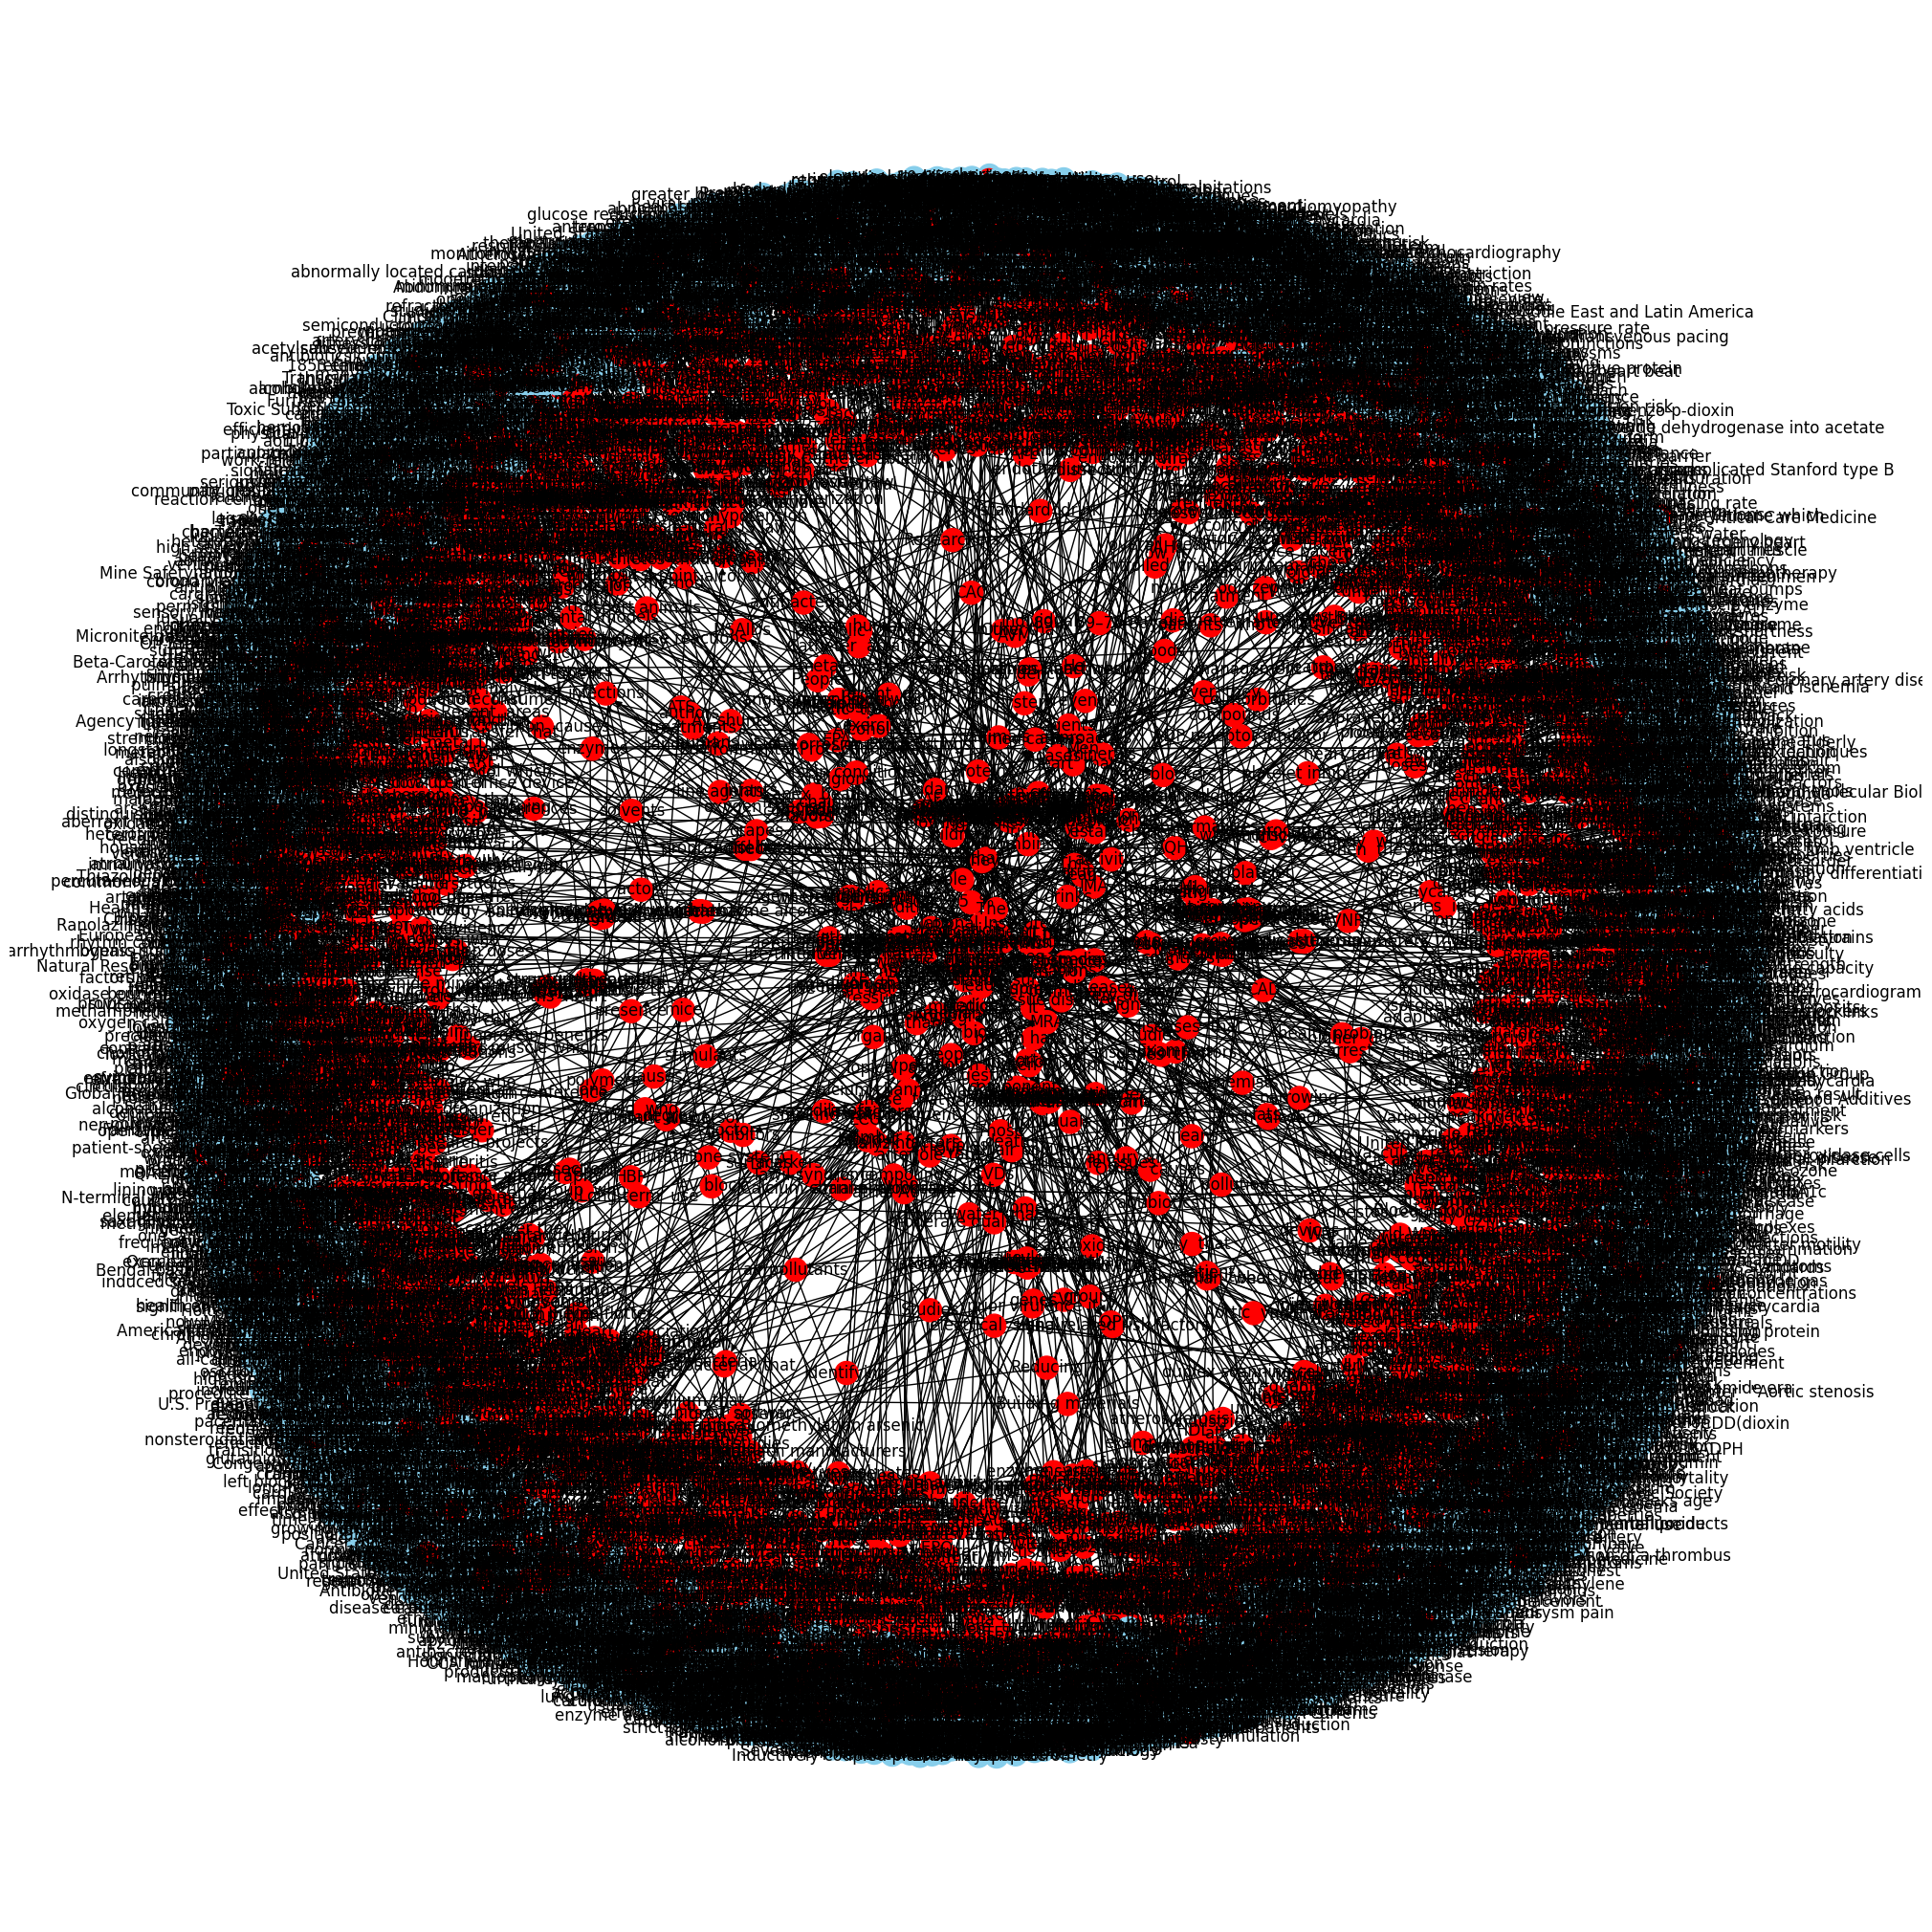

In [19]:
Knowledge_graph=nx.from_pandas_edgelist(df, 'source-node', 'target-node', edge_attr=True, create_using=nx.MultiDiGraph())
for n in Knowledge_graph.nodes():
    Knowledge_graph.nodes[n]['color'] = 'red' if n in sources else 'skyblue'

plt.figure(figsize=(20,20))
colors = [node[1]['color'] for node in Knowledge_graph.nodes(data=True)]
pos = nx.spring_layout(Knowledge_graph)
nx.draw(Knowledge_graph, with_labels=True, node_color=colors, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

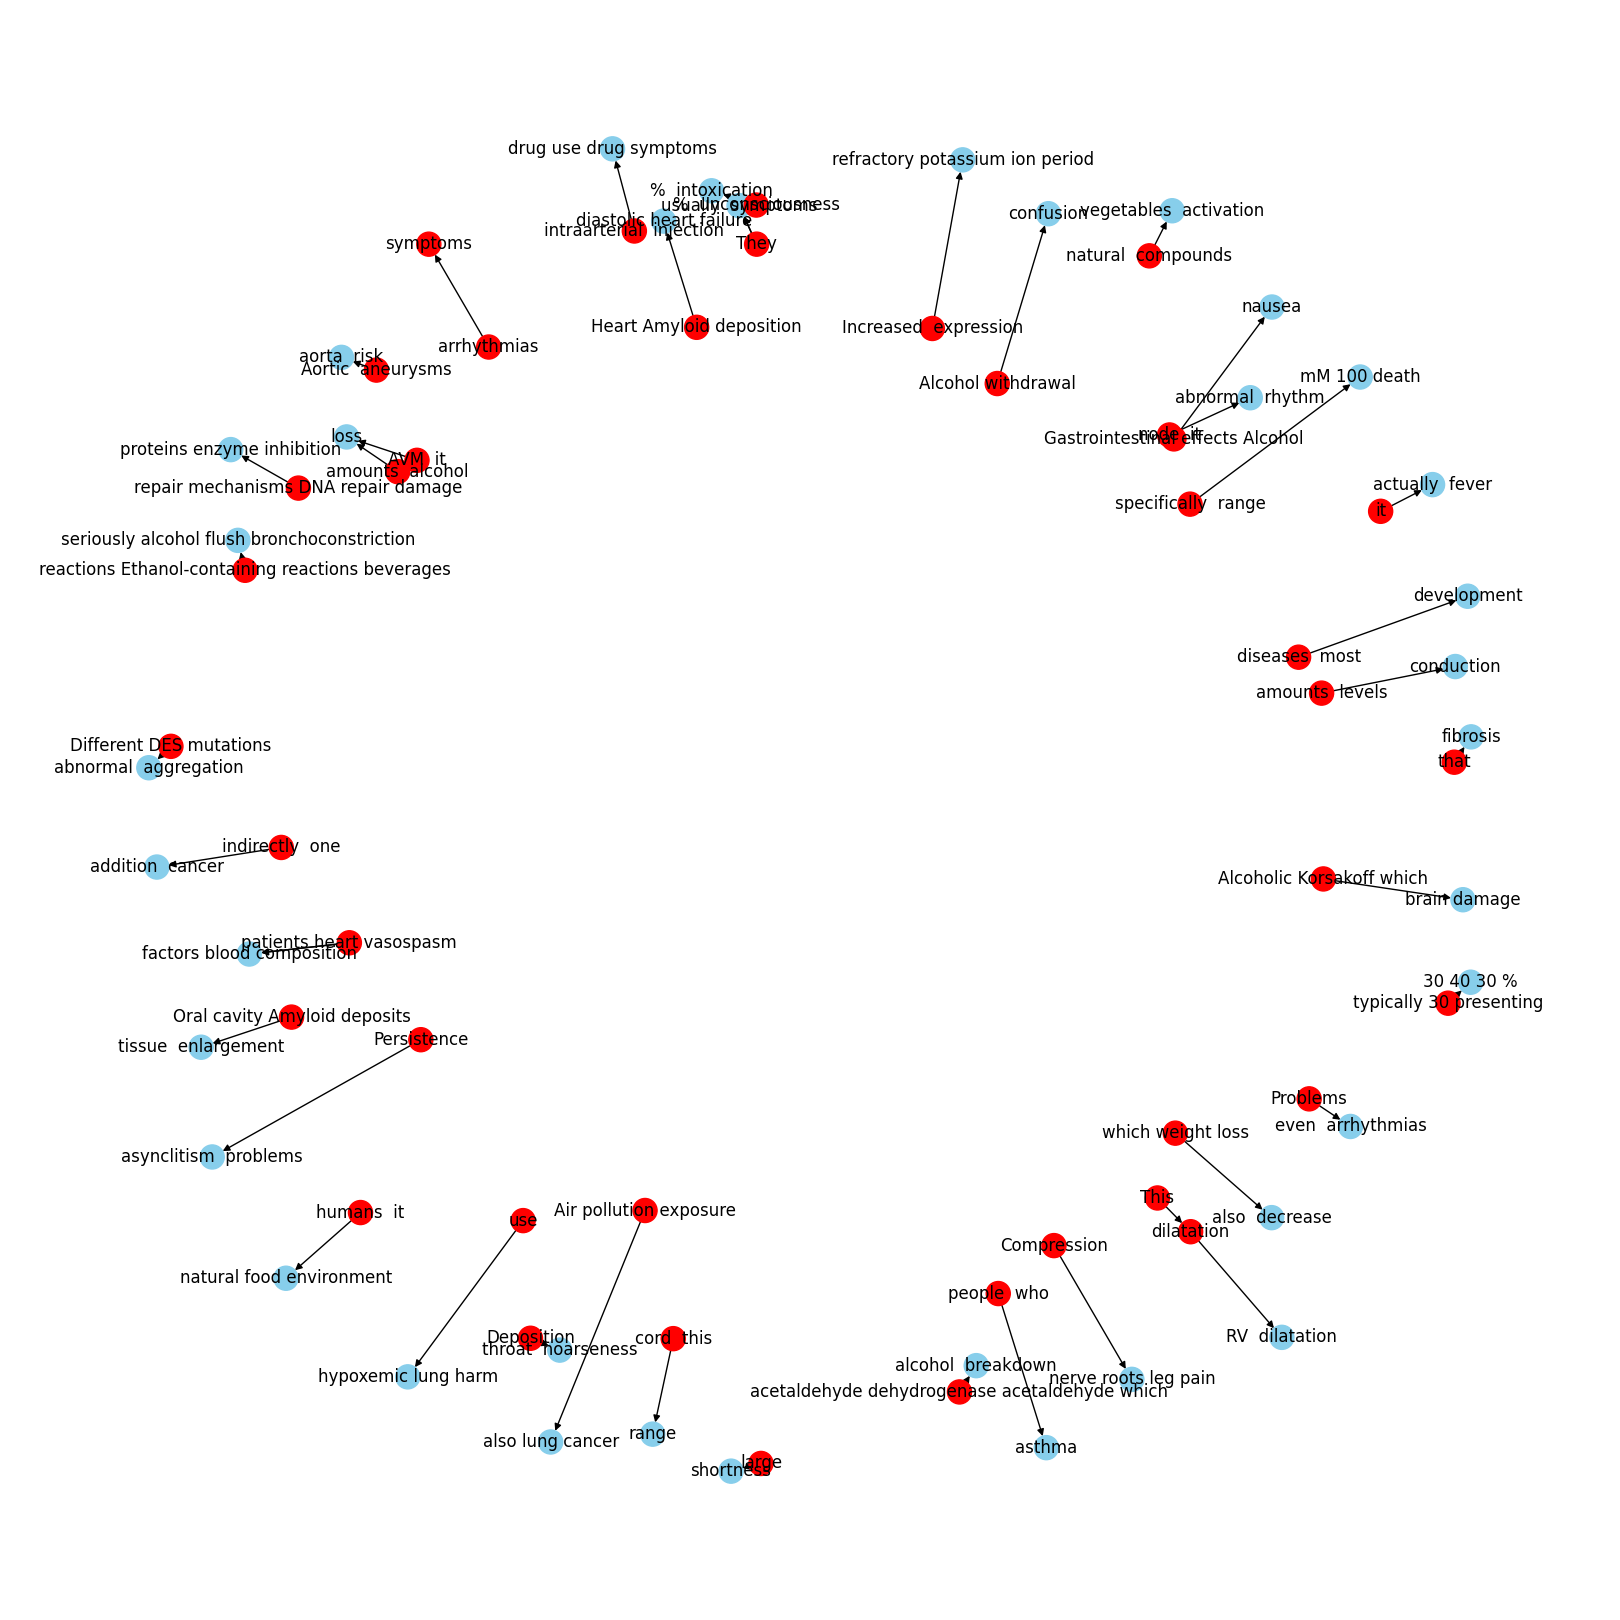

In [20]:
Knowledge_graph1=nx.from_pandas_edgelist(df[df['relation']=='cause'],'source-node', 'target-node',edge_attr=True, create_using=nx.MultiDiGraph())

for n in Knowledge_graph1.nodes():
    Knowledge_graph1.nodes[n]['color'] = 'red' if n in sources else 'skyblue'
    
plt.figure(figsize=(16,16))
colors = [node[1]['color'] for node in Knowledge_graph1.nodes(data=True)]
pos = nx.spring_layout(Knowledge_graph1)
nx.draw(Knowledge_graph1, with_labels=True, node_color=colors, edge_cmap=plt.cm.Reds, pos = pos)
plt.show()